In [14]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV

%precision %.7g
%matplotlib inline

# KNN

## 1. Explore

In [15]:
data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Build and Evaluate Model

In [16]:
predictors = ["BMI", "BloodPressure"]
X = data[predictors]
y = data["Outcome"]

n_neighbors = 5

knn = KNeighborsClassifier(n_neighbors = n_neighbors)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

z = StandardScaler()
z.fit(X_train)
X_train[predictors] = z.transform(X_train)
X_test[predictors] = z.transform(X_test)

knn.fit(X_train,y_train)

X_train

,BMI,BloodPressure
547,0.162131,-0.064768
593,-0.426383,-0.891100
458,0.737852,0.761565
364,0.392419,0.245107
236,0.520357,0.761565
...,...,...
361,-0.260064,0.038524
573,0.366832,-0.477934
607,-1.577824,-0.374642
66,0.085368,0.968148


------------
Index(['BMI', 'BloodPressure'], dtype='object')


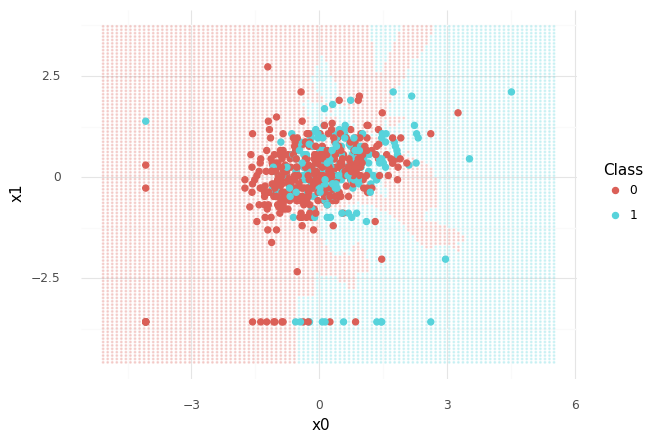

<ggplot: (-9223372036520307445)>


In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plotKNN2D(Xdf,y,k):
    # X can only have 2 dimensions becuase of plotting
    print("------------")
    print(Xdf.columns)
    
    
    Xdf.columns = ["x0", "x1"]

    #grab the range of features for each feature
    x0_range = np.linspace(min(Xdf["x0"]) - np.std(Xdf["x0"]),
                           max(Xdf["x0"]) + np.std(Xdf["x0"]), num = 100)
    x1_range = np.linspace(min(Xdf["x1"]) - np.std(Xdf["x1"]),
                           max(Xdf["x1"]) + np.std(Xdf["x1"]), num = 100)

    #get all possible points on graph
    x0 = np.repeat(x0_range,100)
    x1 = np.tile(x1_range,100)
    x_grid = pd.DataFrame({"x0": x0, "x1": x1})

    #build model
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(Xdf,y)

    # bredict all background points
    p = knn.predict(x_grid)
    x_grid["p"] = p #add to dataframe
    
    #build the plot
    bound = (ggplot(x_grid, aes(x = "x0", y = "x1", color = "factor(p)")) +
                 geom_point(alpha = 0.2, size = 0.2) + theme_minimal() +
                 scale_color_discrete(name = "Class") +
                 geom_point(data = Xdf, mapping = aes(x = "x0", y = "x1", color = "factor(y)"), size = 2))
    print(bound)
    
    
plotKNN2D(X_train,y_train, k = n_neighbors)

In [18]:
knn.score(Xz_test,y_test)

0.525974025974026

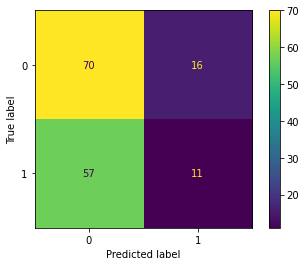

In [19]:
plot_confusion_matrix(knn, Xz_test, y_test)

# Parameter Tuning

## Option 1: By Hand

In [20]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# split training set into train and validation
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2)

# choose possible parameter values to test
poss_k = [1,2,3,4,5,6,7,8,9,10]
acc = {}

# test parameters
for k in poss_k:
    knn3 = KNeighborsClassifier(n_neighbors = k)
    knn3.fit(X_train2,y_train2)
    acc[k] = knn3.score(X_val,y_val)
print(acc)

# choose best param
chosen_k = max(acc, key=acc.get)
print(chosen_k)

# fit model with best param
knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train,y_train)

knn_final.score(X_test,y_test)

{1: 0.5772357723577236, 2: 0.6341463414634146, 3: 0.6747967479674797, 4: 0.6991869918699187, 5: 0.6585365853658537, 6: 0.6910569105691057, 7: 0.6422764227642277, 8: 0.6585365853658537, 9: 0.6504065040650406, 10: 0.6910569105691057}
4


0.6753246753246753

## Option 2 (recommended): Grid Search

In [21]:
# what K do I use??

predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# choose potential values of k
ks = {"n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(knn2,ks, scoring = "accuracy", cv = 5)

knnmod = grid.fit(X_train, y_train)

In [22]:
knnmod.best_estimator_.get_params()["n_neighbors"]

8

In [23]:
knnmod.best_score_
# more things you can pull: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

0.6612554978008797

In [24]:
knnmod.score(X_test,y_test)

0.5909090909090909

## Data Leakage (Reprise)

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# what K do I use??
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# create z score object
z = make_column_transformer((StandardScaler(), ["BMI", "BloodPressure"]))

# make pipeline
pipe = make_pipeline(z, knn2)
print(pipe.get_params().keys())

# choose potential values of k
ks = {"kneighborsclassifier__n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(pipe,ks, scoring = "accuracy", cv = 5, refit = True)

knnmod = grid.fit(X_train, y_train)

knnmod.best_estimator_.get_params()["kneighborsclassifier__n_neighbors"]



dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'kneighborsclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


7

## What else can we Grid Search???

Grid search is a super simple way to choose hyperparameters. There other more efficient ways to tune hyperparameters, but this does a good job in simple cases like the ones we will see in class.

It doesn't just work for K in KNN though! Think about `max_depth` when building a DecisionTree, this can be chosen using `GridSearchCV()` as well.

In [26]:
from sklearn.tree import DecisionTreeClassifier # Decision Tree

# load data from DT lecture
gpa = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/CCfraud.csv")

# set X and y
X = gpa[["home","amount","cashBack"]]
y = gpa["fraud"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# make z score object
z = make_column_transformer((StandardScaler(), ["amount"]))

# make model
tree = DecisionTreeClassifier()

# make pipe
pipe = make_pipeline(z,tree)
print(pipe.get_params().keys())


# choose potential values of k
depths = {"decisiontreeclassifier__max_depth": range(1,9)}

# use grid search to find best parameters
grid = GridSearchCV(pipe,depths, scoring = "accuracy", cv = 5, refit = True)

DTmod = grid.fit(X_train, y_train)


dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'decisiontreeclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_impurity_split', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__presort', 'decisiontreeclassifier__r

In [27]:
DTmod.best_estimator_.get_params()["decisiontreeclassifier__max_depth"]

2

In [28]:
DTmod.predict(X_test)

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [29]:
DTmod

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['amount'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__max_depth': range(1, 9)},
             scoring='accuracy')

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# what K do I use??
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
kf = KFold()

for train,test in kf.split(X):
    X_train = X.iloc[train,]
    X_test = X.iloc[test,]
    y_train = y[train]
    y_test = y[test]
    
    # create model
    knn2 = KNeighborsClassifier()

    # create z score object
    z = make_column_transformer((StandardScaler(), ["BMI", "BloodPressure"]))

    # make pipeline
    pipe = make_pipeline(z, knn2)
    print(pipe.get_params().keys())

    # choose potential values of k
    ks = {"kneighborsclassifier__n_neighbors": range(1,30)}

    # use grid search to find best parameters
    grid = GridSearchCV(pipe,ks, scoring = "accuracy", cv = 5, refit = True)

    knnmod = grid.fit(X_train, y_train)

    knnmod.best_estimator_.get_params()["kneighborsclassifier__n_neighbors"]



dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'kneighborsclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'kneighborsclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers'